In [36]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import os
os.environ['R_HOME'] = 'D:/Program Files/R-4.5.0' #@TODO include in some setup file

from simulation_engine.scenarios.iv.binary_iv import BinaryIV
from simulation_engine.scenarios.iv.continuous_iv import ContinuousIV
from simulation_engine.scenarios.iv.base_iv import IVScenario
from simulation_engine.util.plotting_util import PlottingUtil
from simulation_engine.algorithms.causaloptim import Causaloptim
from simulation_engine.algorithms.zhang_bareinboim import ZhangBareinboim
import pandas as pd
pd.set_option('display.max_columns', None)

#disable warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from simulation_engine.algorithms.zaffalonbounds import ZaffalonBounds

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
function_keys = [
                "identity",
                "sin",
                "cos",
                "tanh",
                "log1p_abs",
                "exp_neg_sq",
                "sigmoid",
                "exp_clipped"
            ]

data = ContinuousIV.run_rolling_b_X_Y_simulations(
    b_range=(-5, 5), N_points=100, replications=1, n=500,
    # allowed_functions=['identity']
)
data

,seed,b_Z_X,b_U_X,b_X_Y,b_U_Y,p_Z,sigma_X,sigma_Y,sigma_U,g_U_X,g_U_Y,squash_X,g_Y,ATE_true,PNS_true,p_Y1_mean,p_Y0_mean,Z,U,X,Y,Y_max,Y_min,X_max,X_min,X_mean,Y_mean
0,450848,-1.263519,-0.769090,-5.00000,0.406804,0.369013,0.541038,0.414039,0.087087,rescaled_identity,sigmoid,softplus,rescaled_identity,-0.105332,0.000,0.000000,0.105332,"[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...","[-0.05860225517143221, -0.0007437401108691601,...","[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, ...","[0.09190744173894813, 0.2574822742472297, 0.06...",0.565284,0.000000,1,0,0.318,0.136538
1,109570,1.210343,0.164600,-4.89899,-1.131477,0.246705,0.721750,0.197153,2.362561,exp_clipped,cos,probit,tanh,-0.376296,0.000,0.011356,0.387652,"[0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, ...","[-0.4068709947385476, 0.46969738277882883, -0....","[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 0.0, 0.0, 0.8873424159028224, 0.0, 0.0, ...",0.894447,0.000000,1,0,0.698,0.058635
2,213951,-2.066011,-0.707195,-4.79798,0.488364,0.900210,0.878169,1.175232,0.232653,sin,sigmoid_shifted,sigmoid,sine_sym,-0.015670,0.380,0.326204,0.341873,"[0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, ...","[0.26739380405652535, 0.28952392660340837, 0.0...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.021309234720873423, 0.0, 0.0399808881577956...",0.999992,0.000000,1,0,0.172,0.322851
3,64502,-1.735314,-1.820649,-4.69697,-0.885982,0.016960,0.168256,1.270945,0.456293,sigmoid_shifted,exp_neg_sq,softplus,sigmoid_shifted,-0.000784,0.480,0.498512,0.499296,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.42107762142238564, 0.02355136855942765, 0.3...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0.9121192791868572, 0.3946528314592688, 0.723...",0.988299,0.001328,1,0,0.228,0.542034
4,578404,1.069095,-0.234335,-4.59596,0.242643,0.371459,0.464980,0.101587,1.957403,rescaled_identity,sigmoid,softplus,log1p_abs,0.673581,1.000,1.000000,0.326419,"[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, ...","[3.5943436229178527, -1.1721531074446438, -2.8...","[0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, ...","[0.28147809575318683, 1.0, 1.0, 0.202779970314...",1.000000,0.000235,1,0,0.462,0.533712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,837677,0.758293,-1.898462,4.59596,1.615718,0.238177,1.704502,0.167925,0.731079,identity,rescaled_identity,softplus,log1p_abs,0.421162,0.878,0.999371,0.578209,"[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, ...","[0.5496055614321251, 1.2390198878376009, 0.321...","[0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, ...","[0.3471917505289014, 0.5200978389051264, 0.573...",1.000000,0.006242,1,0,0.436,0.666515
96,856073,-0.917256,0.648346,4.69697,0.267323,0.945927,1.015236,0.985287,0.203666,bounded_linear,rescaled_identity,tanh_scaled,zero_centered_tanh,0.731440,1.000,0.998879,0.267440,"[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.48065762402820883, 0.38426212091794687, -0....","[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.8719269859081084, 0.0, 0.3409060477734...",0.999999,0.000000,1,0,0.250,0.451544
97,760607,-0.433166,-1.166899,4.79798,-0.598129,0.649936,0.586981,0.437743,0.966184,identity,sine_sym,tanh_scaled,tanh,0.737683,1.000,0.999621,0.261938,"[0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, ...","[-0.35148177891514915, 1.5677428373233455, 0.8...","[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, ...","[0.6181585246910052, 0.6775028955081686, 0.0, ...",0.999996,0.000000,1,0,0.446,0.560414
98,299217,1.298659,0.409495,4.89899,-0.225798,0.521736,0.706258,1.150092,1.483235,sigmoid_shifted,sine_sym,probit,bounded_linear,0.803450,1.000,0.900403,0.096953,"[0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[-1.1629832565608464, -0.12135618217796232, 1....","[1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, ...","[0.8286191614588946, 0.3534409698708304, 1.0, ...",1.000000,0.000000,1,0,0.710,0.664916


In [38]:
contIV = ContinuousIV('IV Dag', data, 1)
contIV.run()
# contIV.binaryIV.data
contIV.data

Running ATE_zhangbareinboim...
Error in ZhangBareinboim: LP for lower bound is invalid or infeasible: status=Infeasible
Error in ZhangBareinboim: LP for lower bound is invalid or infeasible: status=Infeasible
ATE_zhangbareinboim completed in 20.78 seconds.
Running ATE_causaloptim-binned...
Entering binned Binary IV Scenario for algorithm: ATE_causaloptim
Running ATE_causaloptim...
ATE_causaloptim completed in 35.99 seconds.
Total runtime: 35.99 seconds.
Exiting binned Binary IV Scenario.
ATE_causaloptim-binned completed in 35.99 seconds.
Total runtime: 56.78 seconds.


,seed,b_Z_X,b_U_X,b_X_Y,b_U_Y,p_Z,sigma_X,sigma_Y,sigma_U,g_U_X,g_U_Y,squash_X,g_Y,ATE_true,PNS_true,p_Y1_mean,p_Y0_mean,Z,U,X,Y,Y_max,Y_min,X_max,X_min,X_mean,Y_mean,ATE_zhangbareinboim_bound_lower,ATE_zhangbareinboim_bound_upper,ATE_zhangbareinboim_bound_valid,ATE_zhangbareinboim_bound_width,ATE_zhangbareinboim_bound_failed,ATE_causaloptim-binned_bound_lower,ATE_causaloptim-binned_bound_upper,ATE_causaloptim-binned_bound_valid,ATE_causaloptim-binned_bound_width,ATE_causaloptim-binned_bound_failed
0,450848,-1.263519,-0.769090,-5.00000,0.406804,0.369013,0.541038,0.414039,0.087087,rescaled_identity,sigmoid,softplus,rescaled_identity,-0.105332,0.000,0.000000,0.105332,"[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...","[-0.05860225517143221, -0.0007437401108691601,...","[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.565284,0.000000,1,0,0.318,0.136538,-0.186047,0.577354,True,0.763400,False,0.027297,0.351815,False,0.324518,False
1,109570,1.210343,0.164600,-4.89899,-1.131477,0.246705,0.721750,0.197153,2.362561,exp_clipped,cos,probit,tanh,-0.376296,0.000,0.011356,0.387652,"[0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, ...","[-0.4068709947385476, 0.46969738277882883, -0....","[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.894447,0.000000,1,0,0.698,0.058635,-0.721622,0.078170,True,0.799792,False,-0.597089,-0.069439,True,0.527651,False
2,213951,-2.066011,-0.707195,-4.79798,0.488364,0.900210,0.878169,1.175232,0.232653,sin,sigmoid_shifted,sigmoid,sine_sym,-0.015670,0.380,0.326204,0.341873,"[0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, ...","[0.26739380405652535, 0.28952392660340837, 0.0...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...",0.999992,0.000000,1,0,0.172,0.322851,-0.336675,0.266297,True,0.602972,False,-0.331637,0.137856,True,0.469493,False
3,64502,-1.735314,-1.820649,-4.69697,-0.885982,0.016960,0.168256,1.270945,0.456293,sigmoid_shifted,exp_neg_sq,softplus,sigmoid_shifted,-0.000784,0.480,0.498512,0.499296,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.42107762142238564, 0.02355136855942765, 0.3...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...",0.988299,0.001328,1,0,0.228,0.542034,-0.666667,0.099727,True,0.766393,False,-0.666667,-0.051230,False,0.615437,False
4,578404,1.069095,-0.234335,-4.59596,0.242643,0.371459,0.464980,0.101587,1.957403,rescaled_identity,sigmoid,softplus,log1p_abs,0.673581,1.000,1.000000,0.326419,"[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, ...","[3.5943436229178527, -1.1721531074446438, -2.8...","[0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, ...","[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...",1.000000,0.000235,1,0,0.462,0.533712,0.158917,1.000000,True,0.841083,False,0.158917,1.000000,True,0.841083,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,837677,0.758293,-1.898462,4.59596,1.615718,0.238177,1.704502,0.167925,0.731079,identity,rescaled_identity,softplus,log1p_abs,0.421162,0.878,0.999371,0.578209,"[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, ...","[0.5496055614321251, 1.2390198878376009, 0.321...","[0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, ...","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.000000,0.006242,1,0,0.436,0.666515,-0.093226,0.780488,True,0.873714,False,-0.105842,0.780488,True,0.886330,False
96,856073,-0.917256,0.648346,4.69697,0.267323,0.945927,1.015236,0.985287,0.203666,bounded_linear,rescaled_identity,tanh_scaled,zero_centered_tanh,0.731440,1.000,0.998879,0.267440,"[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.48065762402820883, 0.38426212091794687, -0....","[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...",0.999999,0.000000,1,0,0.250,0.451544,0.107353,0.784355,True,

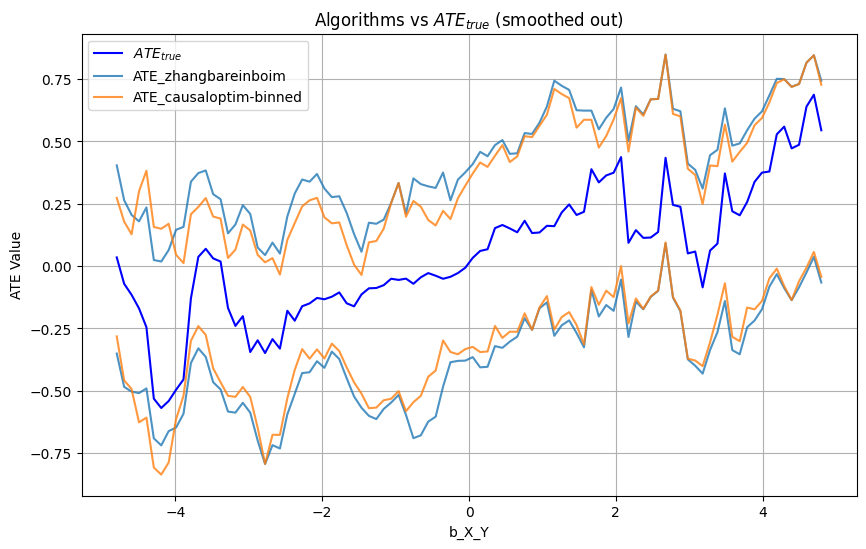

In [ ]:
algs = contIV.get_algorithms('ATE')
PlottingUtil.print_bound_statistics_table(contIV.data, algs)
PlottingUtil.plot_smoothed_query_vs_bounds(contIV.data, 'ATE', algs, 5)

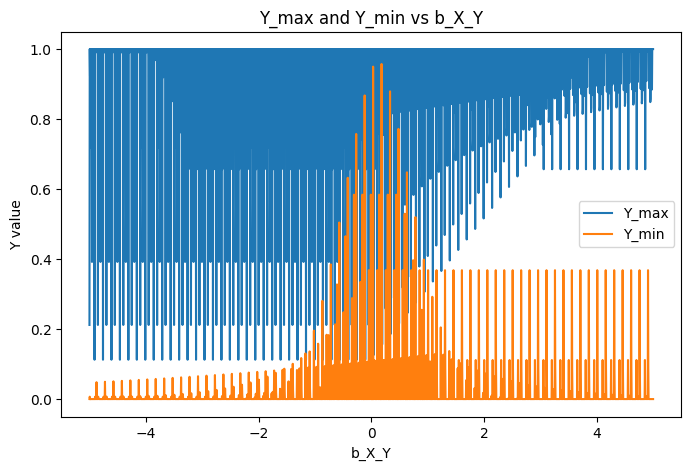

In [107]:
import matplotlib.pyplot as plt

y_label = 'Y'
plt.figure(figsize=(8, 5))
plt.plot(data['b_X_Y'], data[f'{y_label}_max'], label=f'{y_label}_max')
plt.plot(data['b_X_Y'], data[f'{y_label}_min'], label=f'{y_label}_min')
# plt.plot(data['b_X_Y'], data[f'{y_label}_mean'], 'o-', label=f'{y_label}_mean')
plt.xlabel('b_X_Y')
plt.ylabel(f'{y_label} value')
plt.title(f'{y_label}_max and {y_label}_min vs b_X_Y')
plt.legend()
plt.show()

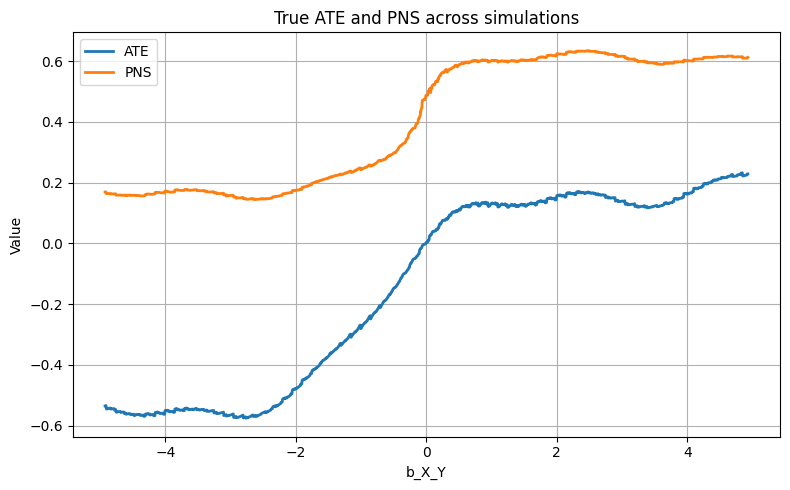

In [105]:
PlottingUtil.plot_ate_pns(data, window=30)

In [4]:
binaryIV = BinaryIV('IV Dag', data)

algorithms = [alg for alg in binaryIV.get_algorithms('ATE') if 'zaffalonbounds' not in alg]
algorithms
runtimes = binaryIV.run_all_bounding_algorithms(algorithms)

Running ATE_2SLS-0.99...
ATE_2SLS-0.99 completed in 0.19 seconds.
Running ATE_2SLS-0.98...
ATE_2SLS-0.98 completed in 0.25 seconds.
Running ATE_causaloptim...
ATE_causaloptim completed in 6.28 seconds.
Running ATE_autobound...
ATE_autobound completed in 4.71 seconds.
Running ATE_entropybounds-0.80...
ATE_entropybounds-0.80 completed in 0.59 seconds.
Running ATE_entropybounds-0.20...
ATE_entropybounds-0.20 completed in 0.59 seconds.
Running ATE_entropybounds-0.10...
ATE_entropybounds-0.10 completed in 0.63 seconds.
Running ATE_nonpara...
ATE_nonpara completed in 0.01 seconds.
Total runtime: 13.26 seconds.


             Algorithm Fail Rate (%) Invalid Rate (%) Net Bound Width
           PNS_nonpara          0.00            16.00          0.1784
       PNS_causaloptim          4.00             9.38          0.4198
         PNS_autobound          1.00             0.00          0.4283
PNS_entropybounds-0.10          0.00             0.00          0.5021
PNS_entropybounds-0.20          0.00             0.00          0.5752
PNS_entropybounds-0.80          0.00             0.00          0.7197
    PNS_zaffalonbounds           N/A              N/A             N/A


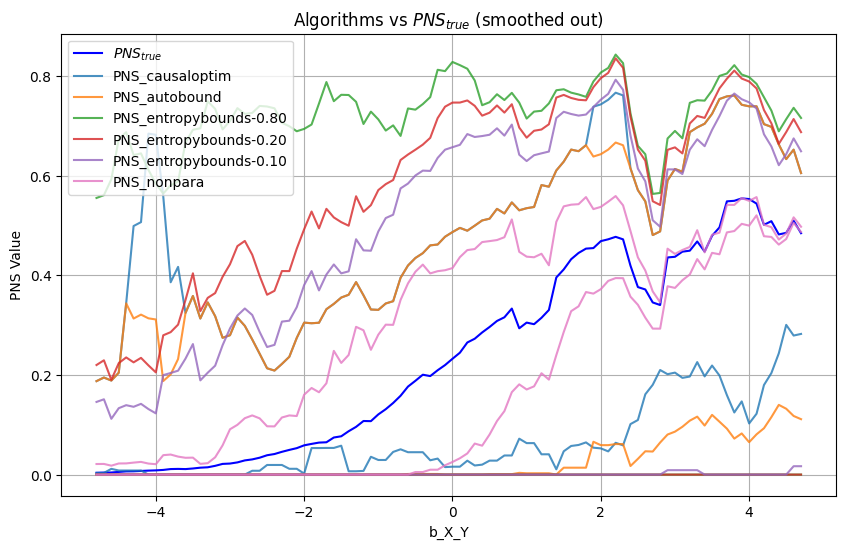

In [28]:
algorithms = list(runtimes['runtimes'].keys())
ate_algs = binaryIV.get_algorithms('PNS')
# PlottingUtil.print_bound_statistics(binaryIV.data, ate_algs)
PlottingUtil.print_bound_statistics_table(binaryIV.data, ate_algs)
PlottingUtil.plot_smoothed_query_vs_bounds(binaryIV.data, 'PNS', ate_algs, 5, False)